In [1]:
import urllib.request
import os.path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


#  utilities 

def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))

#reshape Data
# sample n frame from videos
def my_reshape(data_in ,number_of_frame = 2):
    N, M, H, W = data_in.shape
    n = M-number_of_frame+1
    data_out = np.zeros((n * N, number_of_frame, 64, 64),'uint8')
    for j in range(N):
        for i in range(n):
            data_out[j*n+i] = data_in[j, i:i+number_of_frame]
    
    return data_out

#show filter 
def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    pylab.imshow(im, cmap=cm.gray, interpolation='nearest', **kwargs)
    pylab.show()
    
# Manage Data
class Dataset:
    def __init__(self,data):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._data = data
        self._num_examples = data.shape[0]
        pass


    @property
    def data(self):
        return self._data

    def next_batch(self,batch_size,shuffle = True):
        start = self._index_in_epoch
        if start == 0 and self._epochs_completed == 0:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._data = self.data[idx]  # get list of `num` random samples

        # go to the next batch
        if start + batch_size > self._num_examples:
            self._epochs_completed += 1
            rest_num_examples = self._num_examples - start
            data_rest_part = self.data[start:self._num_examples]
            idx0 = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx0)  # shuffle indexes
            self._data = self.data[idx0]  # get list of `num` random samples

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            data_new_part =  self._data[start:end]  
            return np.concatenate((data_rest_part, data_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._data[start:end]
        
numpy_rng = np.random.RandomState(1)
SMALL = 0.000001

In [2]:

# LOAD DATA
file_name = 'mnist_test_seq.npy'
if not os.path.isfile(file_name):
    print("could not find moving mnist: download it..")
    url = 'http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy'
    urllib.request.urlretrieve(url, file_name)
    print("download complete")
else :
    print ("Data Exist")
    
data = np.load(file_name)
print (data.shape)

num_data = data.shape[1]

idx =  np.arange(0, num_data)
np.random.shuffle(idx)

num_train = int( 0.7 * num_data)
print (num_train)
train_idx = idx[0:num_train]
test_idx = idx [num_train:num_data]

data_train = data[:,train_idx,:,:]
data_test = data[:,test_idx,:,:]


print ("data_train " ,data_train.shape ,"data_test " ,data_test.shape   ) 





Data Exist
(20, 10000, 64, 64)
7000
data_train  (20, 7000, 64, 64) data_test  (20, 3000, 64, 64)


In [3]:
if not os.path.isfile('mean_all.npy'):
    # Get mean and variance of all frames 
    print ('calculate total mean and var')
    data_1 = (my_reshape(data, 1)).astype('float32')
    v,n,h,w = data_1.shape
    data_1 = data_1.reshape((v,h * w))

    mean_all = data_1.mean(0)[None,:]
    data_1 -= mean_all

    var_all = data_1.std(0)  + data_1.std() * 0.1

    np.save("mean_all", mean_all)
    np.save("var_all", var_all)
else :
    print ('load mean and var')
    mean_all = np.load('mean_all.npy')
    var_all = np.load('var_all.npy')

load mean and var


In [4]:
#data for first layer pretraining 
data_1 = my_reshape(data_train, 2)

v,n,h,w = data_1.shape
data_1 = data_1.reshape((v,n,h * w))
print ("data_1 " ,data_1.shape)

x_dim = data_1.shape[2] 

ntrain = data_1.shape[0]
dataset = Dataset(data_1)

#for i in range(10):
#    print(dataset.next_batch(5).shape)
     
# X1 = data_1[:,0,:]
# X2 = data_1[:,1,:]
# data_1 = 0
# print (X1.shape)
# print (X2.shape)

print (data_1.dtype)

data_1  (139980, 2, 4096)
uint8


In [5]:
# Model for first layer pretrainig
numfac1  = 512
nummap1  = 256

input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])

if not os.path.isfile('U1.npy'):
    print ("initialize weights randomly")
    U1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac1)) * 0.01)
    V1 = tf.Variable(tf.random_normal(shape=(x_dim, numfac1)) * 0.01)
    W1 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac1, nummap1)).astype('float32'))

    bias_W1 = tf.Variable(np.zeros(nummap1, dtype='float32'))
else :
    print ("Load weights from file")
    U1 = tf.Variable(np.load("U1.npy"))
    V1 = tf.Variable(np.load("V1.npy"))
    W1 = tf.Variable(np.load("W1.npy"))

    bias_W1 = tf.Variable(np.load("bias_W1.npy"))
    
# bias_U1 = tf.Variable(np.zeros(numfac1, dtype='float32'))
# bias_V1 = tf.Variable(np.zeros(numfac1, dtype='float32'))

# bias_U1_out = tf.Variable(np.zeros(x_dim, dtype='float32'))
# bias_V1_out = tf.Variable(np.zeros(x_dim, dtype='float32'))
# bias_W1_out = tf.Variable(np.zeros(numfac, dtype='float32'))

# m=sig(W(U*X1 . V*X2 ))
M1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)

output_x1 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) ,tf.matmul(input_x2,V1) ),tf.transpose(U1))
output_x2 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) ,tf.matmul(input_x1,U1) ), tf.transpose(V1))

cost_1 = tf.nn.l2_loss(output_x1-input_x1) + tf.nn.l2_loss(output_x2-input_x2)

optimizer_1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_1)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)

Load weights from file


I: 000/1390 E: 000 i:000/139 cost: 2313.445250000
I: 001/1390 E: 000 i:001/139 cost: 2293.069000000
I: 002/1390 E: 000 i:002/139 cost: 2294.827500000
I: 003/1390 E: 000 i:003/139 cost: 2334.592750000
I: 004/1390 E: 000 i:004/139 cost: 2336.225000000
I: 005/1390 E: 000 i:005/139 cost: 2306.714500000
I: 006/1390 E: 000 i:006/139 cost: 2238.099750000
I: 007/1390 E: 000 i:007/139 cost: 2333.212500000
I: 008/1390 E: 000 i:008/139 cost: 2338.609500000
I: 009/1390 E: 000 i:009/139 cost: 2321.800000000
I: 010/1390 E: 000 i:010/139 cost: 2322.565500000
I: 011/1390 E: 000 i:011/139 cost: 2301.255000000
I: 012/1390 E: 000 i:012/139 cost: 2351.237500000
I: 013/1390 E: 000 i:013/139 cost: 2361.452750000
I: 014/1390 E: 000 i:014/139 cost: 2337.478000000
I: 015/1390 E: 000 i:015/139 cost: 2320.046500000
I: 016/1390 E: 000 i:016/139 cost: 2358.216000000
I: 017/1390 E: 000 i:017/139 cost: 2319.196750000
I: 018/1390 E: 000 i:018/139 cost: 2292.323000000
I: 019/1390 E: 000 i:019/139 cost: 2302.092000000


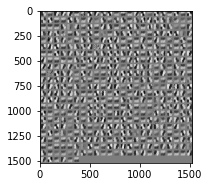

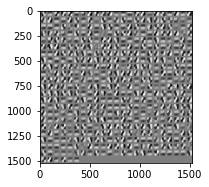

Epoch: 000/010 cost: 2306.141225532
I: 139/1390 E: 001 i:000/139 cost: 2326.707000000
I: 140/1390 E: 001 i:001/139 cost: 2376.606500000
I: 141/1390 E: 001 i:002/139 cost: 2332.919500000
I: 142/1390 E: 001 i:003/139 cost: 2379.156250000
I: 143/1390 E: 001 i:004/139 cost: 2350.163000000
I: 144/1390 E: 001 i:005/139 cost: 2320.516250000
I: 145/1390 E: 001 i:006/139 cost: 2304.886250000
I: 146/1390 E: 001 i:007/139 cost: 2293.696000000
I: 147/1390 E: 001 i:008/139 cost: 2318.080250000
I: 148/1390 E: 001 i:009/139 cost: 2293.196000000
I: 149/1390 E: 001 i:010/139 cost: 2373.894000000
I: 150/1390 E: 001 i:011/139 cost: 2340.594000000
I: 151/1390 E: 001 i:012/139 cost: 2293.545250000
I: 152/1390 E: 001 i:013/139 cost: 2297.224250000
I: 153/1390 E: 001 i:014/139 cost: 2397.797500000
I: 154/1390 E: 001 i:015/139 cost: 2288.684500000
I: 155/1390 E: 001 i:016/139 cost: 2369.389000000
I: 156/1390 E: 001 i:017/139 cost: 2258.390250000
I: 157/1390 E: 001 i:018/139 cost: 2379.844250000
I: 158/1390 E:

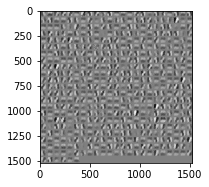

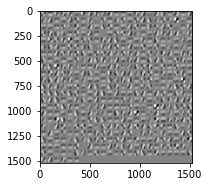

Epoch: 001/010 cost: 2296.933953065
I: 278/1390 E: 002 i:000/139 cost: 2361.002500000
I: 279/1390 E: 002 i:001/139 cost: 2330.387000000
I: 280/1390 E: 002 i:002/139 cost: 2275.880750000
I: 281/1390 E: 002 i:003/139 cost: 2285.669750000
I: 282/1390 E: 002 i:004/139 cost: 2359.280750000
I: 283/1390 E: 002 i:005/139 cost: 2308.537250000
I: 284/1390 E: 002 i:006/139 cost: 2276.352500000
I: 285/1390 E: 002 i:007/139 cost: 2331.910500000
I: 286/1390 E: 002 i:008/139 cost: 2299.360250000
I: 287/1390 E: 002 i:009/139 cost: 2325.676000000
I: 288/1390 E: 002 i:010/139 cost: 2322.278500000
I: 289/1390 E: 002 i:011/139 cost: 2303.208250000
I: 290/1390 E: 002 i:012/139 cost: 2312.154000000
I: 291/1390 E: 002 i:013/139 cost: 2298.039000000
I: 292/1390 E: 002 i:014/139 cost: 2340.148250000
I: 293/1390 E: 002 i:015/139 cost: 2325.629750000
I: 294/1390 E: 002 i:016/139 cost: 2327.077500000
I: 295/1390 E: 002 i:017/139 cost: 2280.282250000
I: 296/1390 E: 002 i:018/139 cost: 2309.132000000
I: 297/1390 E:

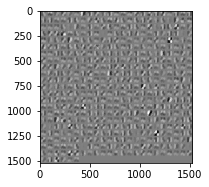

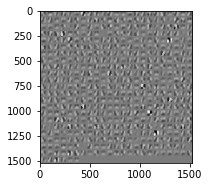

Epoch: 002/010 cost: 2288.096315545
I: 417/1390 E: 003 i:000/139 cost: 2307.673000000
I: 418/1390 E: 003 i:001/139 cost: 2289.053500000
I: 419/1390 E: 003 i:002/139 cost: 2216.827500000
I: 420/1390 E: 003 i:003/139 cost: 2307.611250000
I: 421/1390 E: 003 i:004/139 cost: 2248.918500000
I: 422/1390 E: 003 i:005/139 cost: 2316.807500000
I: 423/1390 E: 003 i:006/139 cost: 2237.519250000
I: 424/1390 E: 003 i:007/139 cost: 2307.754500000
I: 425/1390 E: 003 i:008/139 cost: 2307.722500000
I: 426/1390 E: 003 i:009/139 cost: 2270.073000000
I: 427/1390 E: 003 i:010/139 cost: 2310.544000000
I: 428/1390 E: 003 i:011/139 cost: 2256.607000000
I: 429/1390 E: 003 i:012/139 cost: 2311.747000000
I: 430/1390 E: 003 i:013/139 cost: 2273.566500000
I: 431/1390 E: 003 i:014/139 cost: 2319.377250000
I: 432/1390 E: 003 i:015/139 cost: 2344.516500000
I: 433/1390 E: 003 i:016/139 cost: 2281.524500000
I: 434/1390 E: 003 i:017/139 cost: 2331.282000000
I: 435/1390 E: 003 i:018/139 cost: 2332.779000000
I: 436/1390 E:

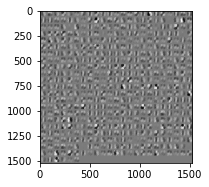

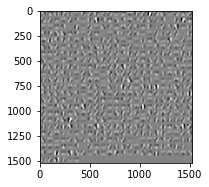

Epoch: 003/010 cost: 2273.499971424
I: 556/1390 E: 004 i:000/139 cost: 2246.388500000
I: 557/1390 E: 004 i:001/139 cost: 2261.622500000
I: 558/1390 E: 004 i:002/139 cost: 2283.878750000
I: 559/1390 E: 004 i:003/139 cost: 2268.752250000
I: 560/1390 E: 004 i:004/139 cost: 2271.023500000
I: 561/1390 E: 004 i:005/139 cost: 2259.319750000
I: 562/1390 E: 004 i:006/139 cost: 2290.774000000
I: 563/1390 E: 004 i:007/139 cost: 2253.056000000
I: 564/1390 E: 004 i:008/139 cost: 2309.234000000
I: 565/1390 E: 004 i:009/139 cost: 2299.654500000
I: 566/1390 E: 004 i:010/139 cost: 2311.678000000
I: 567/1390 E: 004 i:011/139 cost: 2282.444500000
I: 568/1390 E: 004 i:012/139 cost: 2249.460000000
I: 569/1390 E: 004 i:013/139 cost: 2301.627000000
I: 570/1390 E: 004 i:014/139 cost: 2228.254000000
I: 571/1390 E: 004 i:015/139 cost: 2267.274750000
I: 572/1390 E: 004 i:016/139 cost: 2289.177000000
I: 573/1390 E: 004 i:017/139 cost: 2297.916000000
I: 574/1390 E: 004 i:018/139 cost: 2263.685750000
I: 575/1390 E:

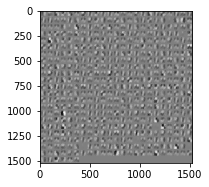

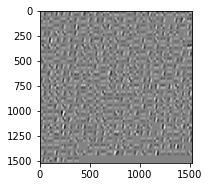

Epoch: 004/010 cost: 2261.805461494
I: 695/1390 E: 005 i:000/139 cost: 2258.083000000
I: 696/1390 E: 005 i:001/139 cost: 2310.958500000
I: 697/1390 E: 005 i:002/139 cost: 2306.621500000
I: 698/1390 E: 005 i:003/139 cost: 2300.453000000
I: 699/1390 E: 005 i:004/139 cost: 2257.848500000
I: 700/1390 E: 005 i:005/139 cost: 2325.191500000
I: 701/1390 E: 005 i:006/139 cost: 2304.483250000
I: 702/1390 E: 005 i:007/139 cost: 2217.815000000
I: 703/1390 E: 005 i:008/139 cost: 2300.592250000
I: 704/1390 E: 005 i:009/139 cost: 2279.866750000
I: 705/1390 E: 005 i:010/139 cost: 2305.255500000
I: 706/1390 E: 005 i:011/139 cost: 2292.015500000
I: 707/1390 E: 005 i:012/139 cost: 2395.493000000
I: 708/1390 E: 005 i:013/139 cost: 2240.113000000
I: 709/1390 E: 005 i:014/139 cost: 2267.245250000
I: 710/1390 E: 005 i:015/139 cost: 2255.689500000
I: 711/1390 E: 005 i:016/139 cost: 2326.998000000
I: 712/1390 E: 005 i:017/139 cost: 2223.975000000
I: 713/1390 E: 005 i:018/139 cost: 2291.919500000
I: 714/1390 E:

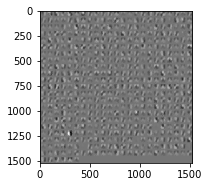

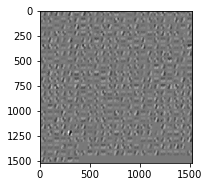

Epoch: 005/010 cost: 2256.805250750
I: 834/1390 E: 006 i:000/139 cost: 2324.434750000
I: 835/1390 E: 006 i:001/139 cost: 2241.315000000
I: 836/1390 E: 006 i:002/139 cost: 2278.763250000
I: 837/1390 E: 006 i:003/139 cost: 2296.634500000
I: 838/1390 E: 006 i:004/139 cost: 2259.348000000
I: 839/1390 E: 006 i:005/139 cost: 2271.085500000
I: 840/1390 E: 006 i:006/139 cost: 2233.156500000
I: 841/1390 E: 006 i:007/139 cost: 2289.802000000
I: 842/1390 E: 006 i:008/139 cost: 2298.690500000
I: 843/1390 E: 006 i:009/139 cost: 2259.245000000
I: 844/1390 E: 006 i:010/139 cost: 2270.427000000
I: 845/1390 E: 006 i:011/139 cost: 2269.951250000
I: 846/1390 E: 006 i:012/139 cost: 2247.486000000
I: 847/1390 E: 006 i:013/139 cost: 2309.359500000
I: 848/1390 E: 006 i:014/139 cost: 2255.471500000
I: 849/1390 E: 006 i:015/139 cost: 2181.182000000
I: 850/1390 E: 006 i:016/139 cost: 2290.222500000
I: 851/1390 E: 006 i:017/139 cost: 2287.423500000
I: 852/1390 E: 006 i:018/139 cost: 2266.472250000
I: 853/1390 E:

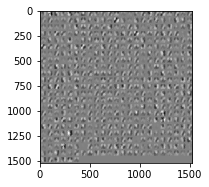

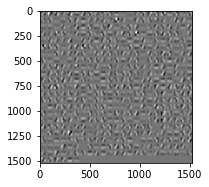

Epoch: 006/010 cost: 2253.012241034
I: 973/1390 E: 007 i:000/139 cost: 2269.796000000
I: 974/1390 E: 007 i:001/139 cost: 2280.410250000
I: 975/1390 E: 007 i:002/139 cost: 2299.789750000
I: 976/1390 E: 007 i:003/139 cost: 2272.100500000
I: 977/1390 E: 007 i:004/139 cost: 2266.010500000
I: 978/1390 E: 007 i:005/139 cost: 2202.238000000
I: 979/1390 E: 007 i:006/139 cost: 2322.373000000
I: 980/1390 E: 007 i:007/139 cost: 2242.754500000
I: 981/1390 E: 007 i:008/139 cost: 2274.734000000
I: 982/1390 E: 007 i:009/139 cost: 2264.592000000
I: 983/1390 E: 007 i:010/139 cost: 2329.566250000
I: 984/1390 E: 007 i:011/139 cost: 2279.977500000
I: 985/1390 E: 007 i:012/139 cost: 2284.842750000
I: 986/1390 E: 007 i:013/139 cost: 2252.261000000
I: 987/1390 E: 007 i:014/139 cost: 2250.863500000
I: 988/1390 E: 007 i:015/139 cost: 2246.688000000
I: 989/1390 E: 007 i:016/139 cost: 2231.290000000
I: 990/1390 E: 007 i:017/139 cost: 2248.232750000
I: 991/1390 E: 007 i:018/139 cost: 2261.676000000
I: 992/1390 E:

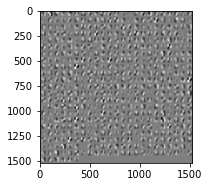

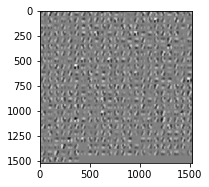

Epoch: 007/010 cost: 2246.576996714
I: 1112/1390 E: 008 i:000/139 cost: 2270.000750000
I: 1113/1390 E: 008 i:001/139 cost: 2259.355750000
I: 1114/1390 E: 008 i:002/139 cost: 2267.005000000
I: 1115/1390 E: 008 i:003/139 cost: 2269.923000000
I: 1116/1390 E: 008 i:004/139 cost: 2229.255000000
I: 1117/1390 E: 008 i:005/139 cost: 2192.679500000
I: 1118/1390 E: 008 i:006/139 cost: 2236.856500000
I: 1119/1390 E: 008 i:007/139 cost: 2286.783250000
I: 1120/1390 E: 008 i:008/139 cost: 2273.080250000
I: 1121/1390 E: 008 i:009/139 cost: 2256.505500000
I: 1122/1390 E: 008 i:010/139 cost: 2247.896000000
I: 1123/1390 E: 008 i:011/139 cost: 2264.818500000
I: 1124/1390 E: 008 i:012/139 cost: 2285.198000000
I: 1125/1390 E: 008 i:013/139 cost: 2225.259500000
I: 1126/1390 E: 008 i:014/139 cost: 2200.061500000
I: 1127/1390 E: 008 i:015/139 cost: 2185.139000000
I: 1128/1390 E: 008 i:016/139 cost: 2230.574500000
I: 1129/1390 E: 008 i:017/139 cost: 2210.917500000
I: 1130/1390 E: 008 i:018/139 cost: 2222.47075

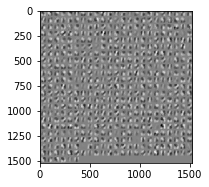

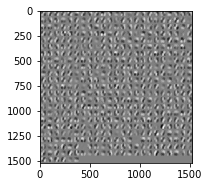

Epoch: 008/010 cost: 2231.848578368
I: 1251/1390 E: 009 i:000/139 cost: 2227.067000000
I: 1252/1390 E: 009 i:001/139 cost: 2266.499000000
I: 1253/1390 E: 009 i:002/139 cost: 2251.584000000
I: 1254/1390 E: 009 i:003/139 cost: 2224.478750000
I: 1255/1390 E: 009 i:004/139 cost: 2259.317000000
I: 1256/1390 E: 009 i:005/139 cost: 2230.842000000
I: 1257/1390 E: 009 i:006/139 cost: 2230.005250000
I: 1258/1390 E: 009 i:007/139 cost: 2238.680250000
I: 1259/1390 E: 009 i:008/139 cost: 2240.094500000
I: 1260/1390 E: 009 i:009/139 cost: 2223.762000000
I: 1261/1390 E: 009 i:010/139 cost: 2243.892250000
I: 1262/1390 E: 009 i:011/139 cost: 2241.232000000
I: 1263/1390 E: 009 i:012/139 cost: 2253.206000000
I: 1264/1390 E: 009 i:013/139 cost: 2334.739000000
I: 1265/1390 E: 009 i:014/139 cost: 2228.223500000
I: 1266/1390 E: 009 i:015/139 cost: 2228.121500000
I: 1267/1390 E: 009 i:016/139 cost: 2246.119500000
I: 1268/1390 E: 009 i:017/139 cost: 2222.027500000
I: 1269/1390 E: 009 i:018/139 cost: 2284.00450

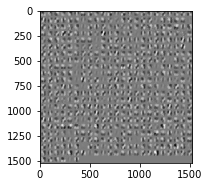

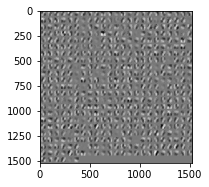

Epoch: 009/010 cost: 2228.938959137


In [6]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 10 


with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
     
            sess.run(optimizer_1, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s})
            sess.run(normalize_U1)
            sess.run(normalize_V1)

            cost_ = sess.run(cost_1, feed_dict={input_x1: batch_x1s.astype('float32'), input_x2: batch_x2s.astype('float32')}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        pylab.subplot(1, 2, 1)
        dispims(U1.eval(sess), 64, 64, 2)
        pylab.subplot(1, 2, 2)
        dispims(V1.eval(sess), 64, 64, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) ) 
        np.save("U1", np.array(U1.eval(sess)))
        np.save("V1", np.array(V1.eval(sess)))
        np.save("W1", np.array(W1.eval(sess)))
        np.save("bias_W1", np.array(bias_W1.eval(sess)))
#   np.save("bias_U1", np.array(bias_U1.eval(sess)))
#   np.save("bias_V1", np.array(bias_V1.eval(sess)))

#   np.save("bias_U1_out", np.array(bias_U1_out.eval(sess)))
#   np.save("bias_V1_out", np.array(bias_V1_out.eval(sess)))
#   np.save("bias_W1_out", np.array(bias_W1_out.eval(sess)))

In [7]:
# Model for first order relational Auto Encoder 
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])

if not os.path.isfile('UR1.npy'):
    U1 = tf.Variable(np.load("U1.npy"))
    V1 = tf.Variable(np.load("V1.npy"))
    W1 = tf.Variable(np.load("W1.npy"))
    bias_W1 = tf.Variable(np.load("bias_W1.npy"))
else:#Continue learning 
    U1 = tf.Variable(np.load("UR1.npy"))
    V1 = tf.Variable(np.load("VR1.npy"))
    W1 = tf.Variable(np.load("WR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WR1.npy"))
    

# m=sig(W(U*X1 . V*X2 ))
M1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)

output_x3 = tf.matmul(tf.multiply(tf.matmul(M1,tf.transpose(W1)) ,tf.matmul(input_x2,V1) ),tf.transpose(U1))
cost_R1 = tf.nn.l2_loss(output_x3-input_x3) 

optimizer_R1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_R1)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)

In [8]:
#data for Second layer pretraining 
data_2 = my_reshape(data_train, 3) # get 3 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)


data_2  (139960, 3, 4096)


I: 000/417 E: 000 i:000/139 cost: 1338.447625000
I: 001/417 E: 000 i:001/139 cost: 1373.069375000
I: 002/417 E: 000 i:002/139 cost: 1378.573000000
I: 003/417 E: 000 i:003/139 cost: 1353.793250000
I: 004/417 E: 000 i:004/139 cost: 1359.795125000
I: 005/417 E: 000 i:005/139 cost: 1358.013125000
I: 006/417 E: 000 i:006/139 cost: 1303.227375000
I: 007/417 E: 000 i:007/139 cost: 1253.963375000
I: 008/417 E: 000 i:008/139 cost: 1264.828500000
I: 009/417 E: 000 i:009/139 cost: 1283.070750000
I: 010/417 E: 000 i:010/139 cost: 1269.440625000
I: 011/417 E: 000 i:011/139 cost: 1314.216125000
I: 012/417 E: 000 i:012/139 cost: 1247.343750000
I: 013/417 E: 000 i:013/139 cost: 1246.712500000
I: 014/417 E: 000 i:014/139 cost: 1298.996750000
I: 015/417 E: 000 i:015/139 cost: 1250.066375000
I: 016/417 E: 000 i:016/139 cost: 1243.017875000
I: 017/417 E: 000 i:017/139 cost: 1237.424000000
I: 018/417 E: 000 i:018/139 cost: 1206.645875000
I: 019/417 E: 000 i:019/139 cost: 1232.016500000
I: 020/417 E: 000 i:

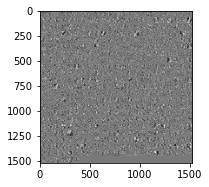

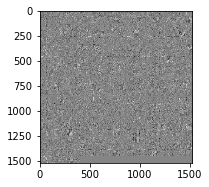

Epoch: 000/003 cost: 1242.569401079
I: 139/417 E: 001 i:000/139 cost: 1220.674750000
I: 140/417 E: 001 i:001/139 cost: 1220.032250000
I: 141/417 E: 001 i:002/139 cost: 1232.974750000
I: 142/417 E: 001 i:003/139 cost: 1213.166250000
I: 143/417 E: 001 i:004/139 cost: 1231.733250000
I: 144/417 E: 001 i:005/139 cost: 1231.546000000
I: 145/417 E: 001 i:006/139 cost: 1256.722500000
I: 146/417 E: 001 i:007/139 cost: 1316.391000000
I: 147/417 E: 001 i:008/139 cost: 1238.660125000
I: 148/417 E: 001 i:009/139 cost: 1281.904750000
I: 149/417 E: 001 i:010/139 cost: 1266.279250000
I: 150/417 E: 001 i:011/139 cost: 1224.678375000
I: 151/417 E: 001 i:012/139 cost: 1184.036625000
I: 152/417 E: 001 i:013/139 cost: 1235.419250000
I: 153/417 E: 001 i:014/139 cost: 1248.698250000
I: 154/417 E: 001 i:015/139 cost: 1282.271875000
I: 155/417 E: 001 i:016/139 cost: 1258.081375000
I: 156/417 E: 001 i:017/139 cost: 1256.148000000
I: 157/417 E: 001 i:018/139 cost: 1247.723750000
I: 158/417 E: 001 i:019/139 cost:

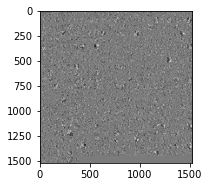

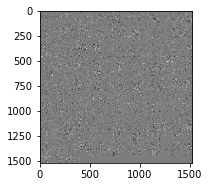

Epoch: 001/003 cost: 1235.550391183
I: 278/417 E: 002 i:000/139 cost: 1248.006750000
I: 279/417 E: 002 i:001/139 cost: 1247.994500000
I: 280/417 E: 002 i:002/139 cost: 1252.344875000
I: 281/417 E: 002 i:003/139 cost: 1239.943250000
I: 282/417 E: 002 i:004/139 cost: 1216.324750000
I: 283/417 E: 002 i:005/139 cost: 1240.282750000
I: 284/417 E: 002 i:006/139 cost: 1247.178875000
I: 285/417 E: 002 i:007/139 cost: 1273.287125000
I: 286/417 E: 002 i:008/139 cost: 1230.288000000
I: 287/417 E: 002 i:009/139 cost: 1241.103125000
I: 288/417 E: 002 i:010/139 cost: 1204.345500000
I: 289/417 E: 002 i:011/139 cost: 1217.763375000
I: 290/417 E: 002 i:012/139 cost: 1254.976000000
I: 291/417 E: 002 i:013/139 cost: 1266.663750000
I: 292/417 E: 002 i:014/139 cost: 1226.458250000
I: 293/417 E: 002 i:015/139 cost: 1290.807625000
I: 294/417 E: 002 i:016/139 cost: 1227.356000000
I: 295/417 E: 002 i:017/139 cost: 1233.630375000
I: 296/417 E: 002 i:018/139 cost: 1243.600875000
I: 297/417 E: 002 i:019/139 cost:

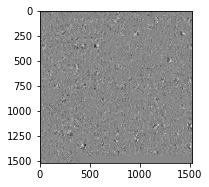

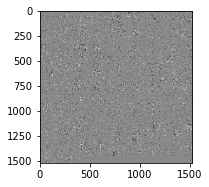

Epoch: 002/003 cost: 1235.077072021


In [10]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 3 

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            batch_x3s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
            batch_x3s /= var_all
     
            sess.run(optimizer_R1, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s})
            sess.run(normalize_U1)
            sess.run(normalize_V1)

            cost_ = sess.run(cost_R1, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        pylab.subplot(1, 2, 1)
        dispims(U1.eval(sess), 64, 64, 2)
        pylab.subplot(1, 2, 2)
        dispims(V1.eval(sess), 64, 64, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) ) 
        np.save("UR1", np.array(U1.eval(sess)))
        np.save("VR1", np.array(V1.eval(sess)))
        np.save("WR1", np.array(W1.eval(sess)))
        np.save("bias_WR1", np.array(bias_W1.eval(sess)))

In [11]:
# Model for Second layer pretrainig
numfac2  = 512
nummap2  = 256

#first layer fixed 
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])

# weights
U1 = tf.constant(np.load("U1.npy"))
V1 = tf.constant(np.load("V1.npy"))
W1 = tf.constant(np.load("W1.npy"))

bias_W1 = tf.constant(np.load("bias_W1.npy"))


M1_1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)
M1_2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x2,U1) ,tf.matmul(input_x3,V1) ), W1)+ bias_W1)

#second layer 
if not os.path.isfile('U2.npy'): 
    U2 = tf.Variable(tf.random_normal(shape=(nummap1, numfac2)) * 0.01)
    V2 = tf.Variable(tf.random_normal(shape=(nummap1, numfac2)) * 0.01)
    W2 = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=( numfac2, nummap2)).astype('float32'))

    bias_W2 = tf.Variable(np.zeros(nummap2, dtype='float32'))
else :#load saved weights and Continue 
    print ("Load weights for second layer from file")
    U2 = tf.Variable(np.load("U2.npy"))
    V2 = tf.Variable(np.load("V2.npy"))
    W2 = tf.Variable(np.load("W2.npy"))

    bias_W2 = tf.Variable(np.load("bias_W2.npy"))
    
    
M2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(M1_1,U2) ,tf.matmul(M1_2,V2) ), W2)+ bias_W2)


output_M1_1 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_2,V2) ),tf.transpose(U2))
output_M1_2 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_1,U2) ),tf.transpose(V2))

cost_2 = tf.nn.l2_loss(output_M1_1-M1_1) + tf.nn.l2_loss(output_M1_2-M1_1)

optimizer_2 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_2)

U2_normalized = tf.nn.l2_normalize(U2, [0,1], epsilon=1e-12, name=None)
V2_normalized = tf.nn.l2_normalize(V2, [0,1], epsilon=1e-12, name=None)

normalize_U2 = U2.assign(U2_normalized)
normalize_V2 = V2.assign(V2_normalized)

Load weights for second layer from file


In [12]:
#data for Second layer pretraining 
data_2 = my_reshape(data_train, 3) # get 3 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)


data_2  (139960, 3, 4096)


I: 000/417 E: 000 i:000/139 cost: 24.634117187
I: 001/417 E: 000 i:001/139 cost: 23.844683594
I: 002/417 E: 000 i:002/139 cost: 24.049046875
I: 003/417 E: 000 i:003/139 cost: 23.742912109
I: 004/417 E: 000 i:004/139 cost: 24.564837891
I: 005/417 E: 000 i:005/139 cost: 23.210320312
I: 006/417 E: 000 i:006/139 cost: 24.327027344
I: 007/417 E: 000 i:007/139 cost: 23.374730469
I: 008/417 E: 000 i:008/139 cost: 23.878125000
I: 009/417 E: 000 i:009/139 cost: 23.530406250
I: 010/417 E: 000 i:010/139 cost: 24.054703125
I: 011/417 E: 000 i:011/139 cost: 23.834746094
I: 012/417 E: 000 i:012/139 cost: 23.960570312
I: 013/417 E: 000 i:013/139 cost: 24.044007812
I: 014/417 E: 000 i:014/139 cost: 23.663312500
I: 015/417 E: 000 i:015/139 cost: 23.741621094
I: 016/417 E: 000 i:016/139 cost: 23.460130859
I: 017/417 E: 000 i:017/139 cost: 23.196791016
I: 018/417 E: 000 i:018/139 cost: 23.721208984
I: 019/417 E: 000 i:019/139 cost: 23.984097656
I: 020/417 E: 000 i:020/139 cost: 23.613101562
I: 021/417 E:

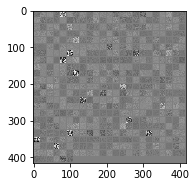

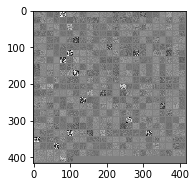

Epoch: 000/003 cost: 23.392720004
I: 139/417 E: 001 i:000/139 cost: 23.779060547
I: 140/417 E: 001 i:001/139 cost: 23.566265625
I: 141/417 E: 001 i:002/139 cost: 22.793347656
I: 142/417 E: 001 i:003/139 cost: 23.742798828
I: 143/417 E: 001 i:004/139 cost: 23.564755859
I: 144/417 E: 001 i:005/139 cost: 23.540507812
I: 145/417 E: 001 i:006/139 cost: 23.241830078
I: 146/417 E: 001 i:007/139 cost: 23.107720703
I: 147/417 E: 001 i:008/139 cost: 23.083259766
I: 148/417 E: 001 i:009/139 cost: 23.441619141
I: 149/417 E: 001 i:010/139 cost: 23.168613281
I: 150/417 E: 001 i:011/139 cost: 23.738156250
I: 151/417 E: 001 i:012/139 cost: 23.695673828
I: 152/417 E: 001 i:013/139 cost: 23.060294922
I: 153/417 E: 001 i:014/139 cost: 23.321335937
I: 154/417 E: 001 i:015/139 cost: 23.229562500
I: 155/417 E: 001 i:016/139 cost: 23.577164062
I: 156/417 E: 001 i:017/139 cost: 23.268326172
I: 157/417 E: 001 i:018/139 cost: 22.805312500
I: 158/417 E: 001 i:019/139 cost: 23.468001953
I: 159/417 E: 001 i:020/13

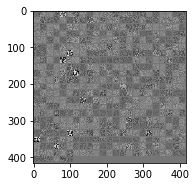

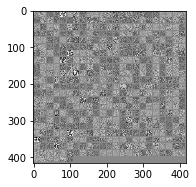

Epoch: 001/003 cost: 23.272173369
I: 278/417 E: 002 i:000/139 cost: 23.052447266
I: 279/417 E: 002 i:001/139 cost: 23.060152344
I: 280/417 E: 002 i:002/139 cost: 23.305046875
I: 281/417 E: 002 i:003/139 cost: 23.675160156
I: 282/417 E: 002 i:004/139 cost: 23.442115234
I: 283/417 E: 002 i:005/139 cost: 23.364886719
I: 284/417 E: 002 i:006/139 cost: 23.285265625
I: 285/417 E: 002 i:007/139 cost: 23.757945312
I: 286/417 E: 002 i:008/139 cost: 23.542011719
I: 287/417 E: 002 i:009/139 cost: 23.733316406
I: 288/417 E: 002 i:010/139 cost: 23.293031250
I: 289/417 E: 002 i:011/139 cost: 23.891914062
I: 290/417 E: 002 i:012/139 cost: 23.317363281
I: 291/417 E: 002 i:013/139 cost: 23.128886719
I: 292/417 E: 002 i:014/139 cost: 23.626460937
I: 293/417 E: 002 i:015/139 cost: 22.723689453
I: 294/417 E: 002 i:016/139 cost: 23.520445313
I: 295/417 E: 002 i:017/139 cost: 23.477300781
I: 296/417 E: 002 i:018/139 cost: 23.195722656
I: 297/417 E: 002 i:019/139 cost: 23.325496094
I: 298/417 E: 002 i:020/13

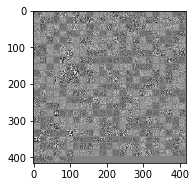

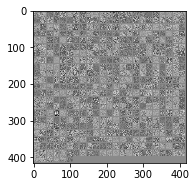

Epoch: 002/003 cost: 23.227715327


In [13]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 3 

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            batch_x3s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
            batch_x3s /= var_all
     
            sess.run(optimizer_2, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s})
            sess.run(normalize_U2)
            sess.run(normalize_V2)

            cost_ = sess.run(cost_2, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        pylab.subplot(1, 2, 1)
        dispims(U2.eval(sess), 16, 16, 2)
        pylab.subplot(1, 2, 2)
        dispims(V2.eval(sess), 16, 16, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) ) 
        np.save("U2", np.array(U2.eval(sess)))
        np.save("V2", np.array(V2.eval(sess)))
        np.save("W2", np.array(W2.eval(sess)))
        np.save("bias_W2", np.array(bias_W2.eval(sess)))

In [14]:
# Model of  second order relational auto encoder
input_x1 = tf.placeholder(tf.float32, [None, x_dim])
input_x2 = tf.placeholder(tf.float32, [None, x_dim])
input_x3 = tf.placeholder(tf.float32, [None, x_dim])
input_x4 = tf.placeholder(tf.float32, [None, x_dim])

# weights for first layer URR1
if not os.path.isfile('URR1.npy'): 
    U1 = tf.Variable(np.load("UR1.npy"))
    V1 = tf.Variable(np.load("VR1.npy"))
    W1 = tf.Variable(np.load("WR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WR1.npy"))

    #weights for second layer 
    U2 = tf.Variable(np.load("U2.npy"))
    V2 = tf.Variable(np.load("V2.npy"))
    W2 = tf.Variable(np.load("W2.npy"))
    bias_W2 = tf.Variable(np.load("bias_W2.npy"))
else :
    U1 = tf.Variable(np.load("URR1.npy"))
    V1 = tf.Variable(np.load("VRR1.npy"))
    W1 = tf.Variable(np.load("WRR1.npy"))
    bias_W1 = tf.Variable(np.load("bias_WRR1.npy"))

    #weights for second layer 
    U2 = tf.Variable(np.load("URR2.npy"))
    V2 = tf.Variable(np.load("VRR2.npy"))
    W2 = tf.Variable(np.load("WRR2.npy"))
    bias_W2 = tf.Variable(np.load("bias_WRR2.npy"))


M1_1 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x1,U1) ,tf.matmul(input_x2,V1) ), W1)+ bias_W1)
M1_2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(input_x2,U1) ,tf.matmul(input_x3,V1) ), W1)+ bias_W1)

M2 =  tf.sigmoid(tf.matmul(tf.multiply(tf.matmul(M1_1,U2) ,tf.matmul(M1_2,V2) ), W2)+ bias_W2)

output_M1_3 = tf.matmul(tf.multiply(tf.matmul(M2,tf.transpose(W2)) ,tf.matmul(M1_2,V2) ),tf.transpose(U2))
output_x4 = tf.matmul(tf.multiply(tf.matmul(output_M1_3,tf.transpose(W1)) ,tf.matmul(input_x3,V1) ),tf.transpose(U1))

cost_RR = tf.nn.l2_loss(output_x4-input_x4)

optimizer_RR = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost_RR)

U1_normalized = tf.nn.l2_normalize(U1, [0,1], epsilon=1e-12, name=None)
V1_normalized = tf.nn.l2_normalize(V1, [0,1], epsilon=1e-12, name=None)
U2_normalized = tf.nn.l2_normalize(U2, [0,1], epsilon=1e-12, name=None)
V2_normalized = tf.nn.l2_normalize(V2, [0,1], epsilon=1e-12, name=None)

normalize_U1 = U1.assign(U1_normalized)
normalize_V1 = V1.assign(V1_normalized)
normalize_U2 = U2.assign(U2_normalized)
normalize_V2 = V2.assign(V2_normalized)


In [15]:
#data for second order relational auto encoder
data_2 = my_reshape(data_train, 4) # get 4 frame in each row
 
v,n,h,w = data_2.shape
data_2 = data_2.reshape((v,n,h * w))
print ("data_2 " ,data_2.shape)

ntrain = data_2.shape[0]
dataset2 = Dataset(data_2)

data_2  (139940, 4, 4096)


I: 000/139 E: 000 i:000/139 cost: 1284.404625000
I: 001/139 E: 000 i:001/139 cost: 1240.788875000
I: 002/139 E: 000 i:002/139 cost: 1264.790750000
I: 003/139 E: 000 i:003/139 cost: 1239.360125000
I: 004/139 E: 000 i:004/139 cost: 1185.059000000
I: 005/139 E: 000 i:005/139 cost: 1254.596625000
I: 006/139 E: 000 i:006/139 cost: 1246.982875000
I: 007/139 E: 000 i:007/139 cost: 1214.991375000
I: 008/139 E: 000 i:008/139 cost: 1245.752375000
I: 009/139 E: 000 i:009/139 cost: 1230.659250000
I: 010/139 E: 000 i:010/139 cost: 1252.848125000
I: 011/139 E: 000 i:011/139 cost: 1250.227125000
I: 012/139 E: 000 i:012/139 cost: 1307.602750000
I: 013/139 E: 000 i:013/139 cost: 1215.614875000
I: 014/139 E: 000 i:014/139 cost: 1284.530500000
I: 015/139 E: 000 i:015/139 cost: 1258.203000000
I: 016/139 E: 000 i:016/139 cost: 1243.854625000
I: 017/139 E: 000 i:017/139 cost: 1221.180250000
I: 018/139 E: 000 i:018/139 cost: 1286.956875000
I: 019/139 E: 000 i:019/139 cost: 1260.935875000
I: 020/139 E: 000 i:

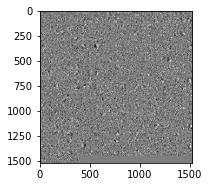

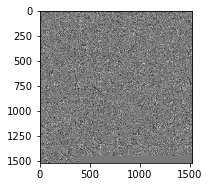

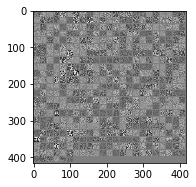

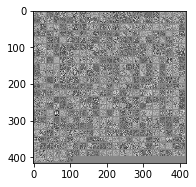

Epoch: 000/001 cost: 1236.035102544


In [16]:
batch_size = 1000
num_batches = int(ntrain/batch_size)
training_epochs = 1 

with tf.Session() as sess:
    import pylab
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        total_cost = 0
        for batch_id in range(num_batches):
            batch = (dataset2.next_batch(batch_size)).astype('float32')
            batch_x1s = batch[:,0,:]
            batch_x2s = batch[:,1,:]
            batch_x3s = batch[:,2,:]
            batch_x4s = batch[:,3,:]
            
            batch_x1s -= mean_all
            batch_x2s -= mean_all
            batch_x3s -= mean_all
            batch_x4s -= mean_all
            
            batch_x1s /= var_all
            batch_x2s /= var_all
            batch_x3s /= var_all
            batch_x4s /= var_all
     
            sess.run(optimizer_RR, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s, input_x4: batch_x4s})
            sess.run(normalize_U1)
            sess.run(normalize_V1)
            sess.run(normalize_U2)
            sess.run(normalize_V2)
            cost_ = sess.run(cost_RR, feed_dict={input_x1: batch_x1s, input_x2: batch_x2s, input_x3: batch_x3s, input_x4: batch_x4s}) 
            total_cost += cost_
            print ("I: %03d/%03d E: %03d i:%03d/%03d cost: %.9f" % (epoch*num_batches+batch_id,training_epochs*num_batches ,epoch,batch_id,num_batches,cost_/batch_size) ) 

        pylab.subplot(1, 2, 1)
        dispims(U1.eval(sess), 64, 64, 2)
        pylab.subplot(1, 2, 2)
        dispims(V1.eval(sess), 64, 64, 2)
        
        pylab.subplot(1, 2, 1)
        dispims(U2.eval(sess), 16, 16, 2)
        pylab.subplot(1, 2, 2)
        dispims(V2.eval(sess), 16, 16, 2)
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,total_cost / ntrain) )
        np.save("URR1", np.array(U1.eval(sess)))
        np.save("VRR1", np.array(V1.eval(sess)))
        np.save("WRR1", np.array(W1.eval(sess)))
        np.save("bias_WRR1", np.array(bias_W1.eval(sess)))
        np.save("URR2", np.array(U2.eval(sess)))
        np.save("VRR2", np.array(V2.eval(sess)))
        np.save("WRR2", np.array(W2.eval(sess)))
        np.save("bias_WRR2", np.array(bias_W2.eval(sess)))